In [1]:
# Import packages
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

import matplotlib.pyplot as plt
import seaborn as sns

# Defining all our palette colours.
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

# Load and Merge Datasets
In this section we will load the *video game global sales* dataset, and the *video games developer base country* dataset. We will then merge the two datasets to create a single dataset that contains all the information we need to answer the questions we have.

In [2]:
# Import dataset
data_file_path = "datasets/video-game-sales.csv"
companie_region_path = "datasets/video-games-developers.csv"

# Load the data
df = pd.read_csv(data_file_path)
df_companies = pd.read_csv(companie_region_path)

# Merge the two datasets
df = pd.merge(df, df_companies[['Developer', 'Country']], left_on='Publisher', right_on='Developer', how='left')
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Developer,Country
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,Nintendo,Japan
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,Nintendo,Japan
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,Nintendo,Japan
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,Nintendo,Japan
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,Nintendo,Japan


# The Top-selling Game of Each Year
This code snippet is designed to visualize the total video game sales of each year, and contains the top-selling game of each specific year.

In [3]:
# Get the top game in each year
top_games = df.sort_values('Global_Sales', ascending=False).drop_duplicates(['Year'])

# Create the plot
fig = px.bar(top_games, x='Year', y='Global_Sales', color='Year', text='Name', 
             labels={'Year': 'Year', 'Global_Sales': 'Total Sales', 'Name': 'Top Game'}, 
             title='Top Game in Each Year')

fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

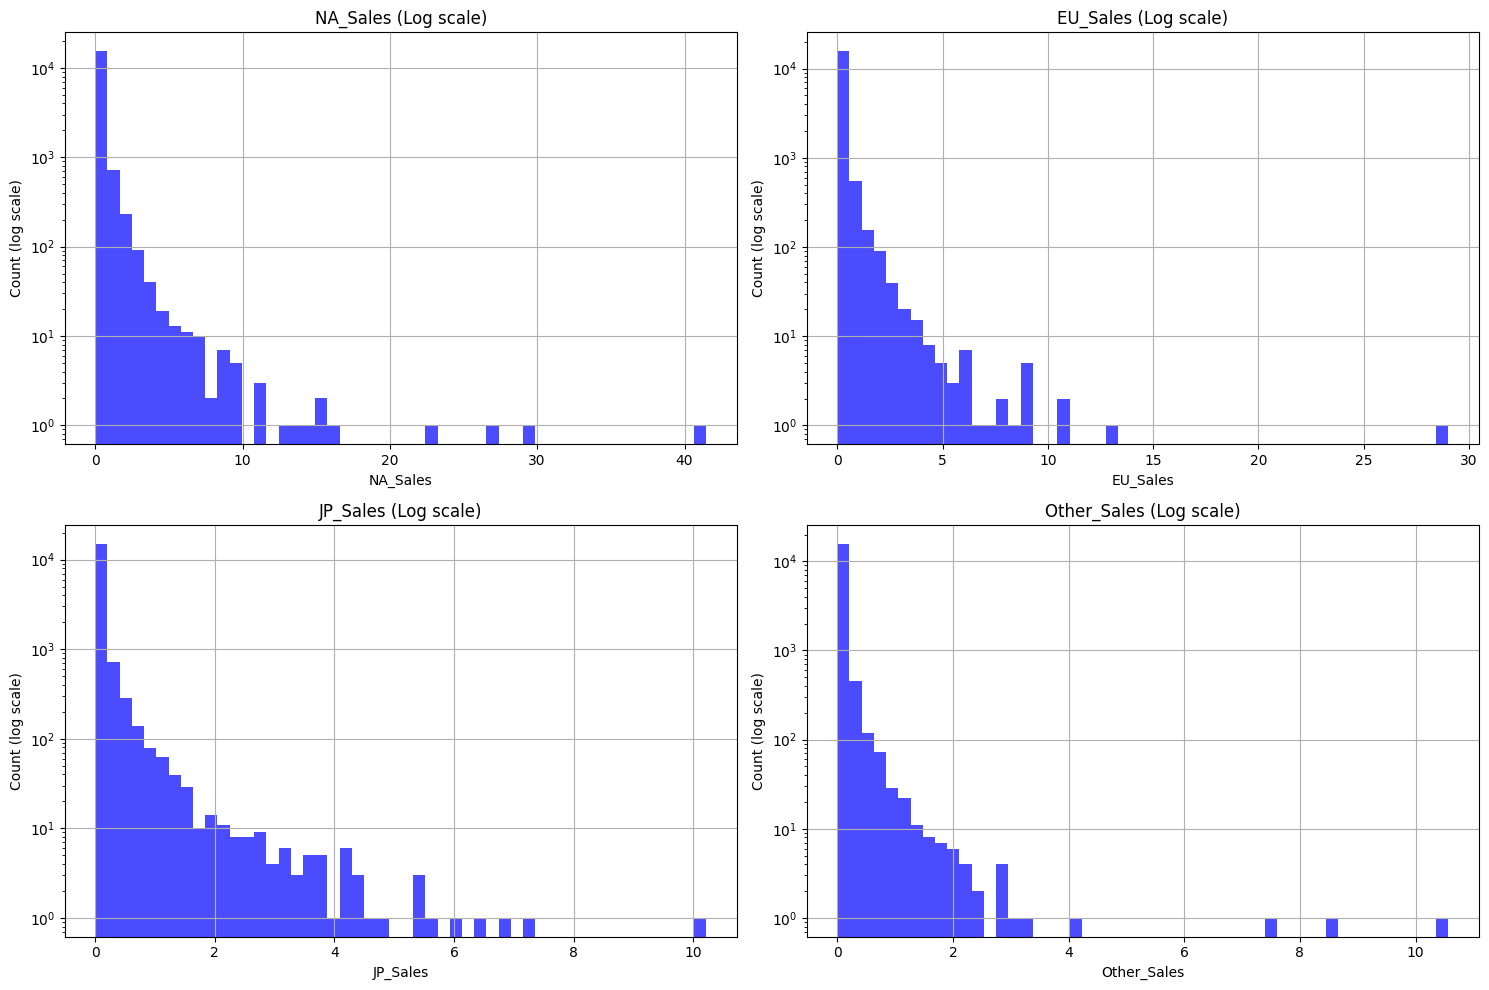

In [4]:
# Function to plot histograms with log scale
def plot_log_histograms(df, columns, bins=50):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    axes = axes.ravel()  # Flatten the array for easy iteration
    
    for i, column in enumerate(columns):
        # Plot with a log scale for the y-axis to better visualize the distribution
        axes[i].hist(df[column], bins=bins, color='blue', alpha=0.7)
        axes[i].set_title(f'{column} (Log scale)')
        axes[i].set_yscale('log')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Count (log scale)')
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()

# Columns to plot
columns_to_plot = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

# Plot the histograms
plot_log_histograms(df, columns_to_plot)

# Most Popular Video Game Producers by Country
The following code snippet is designed to create a grid of horizontal bar charts, depicting the top-selling video game publishers for different regions (North America, Europe, Japan, and Other Regions) and globally.

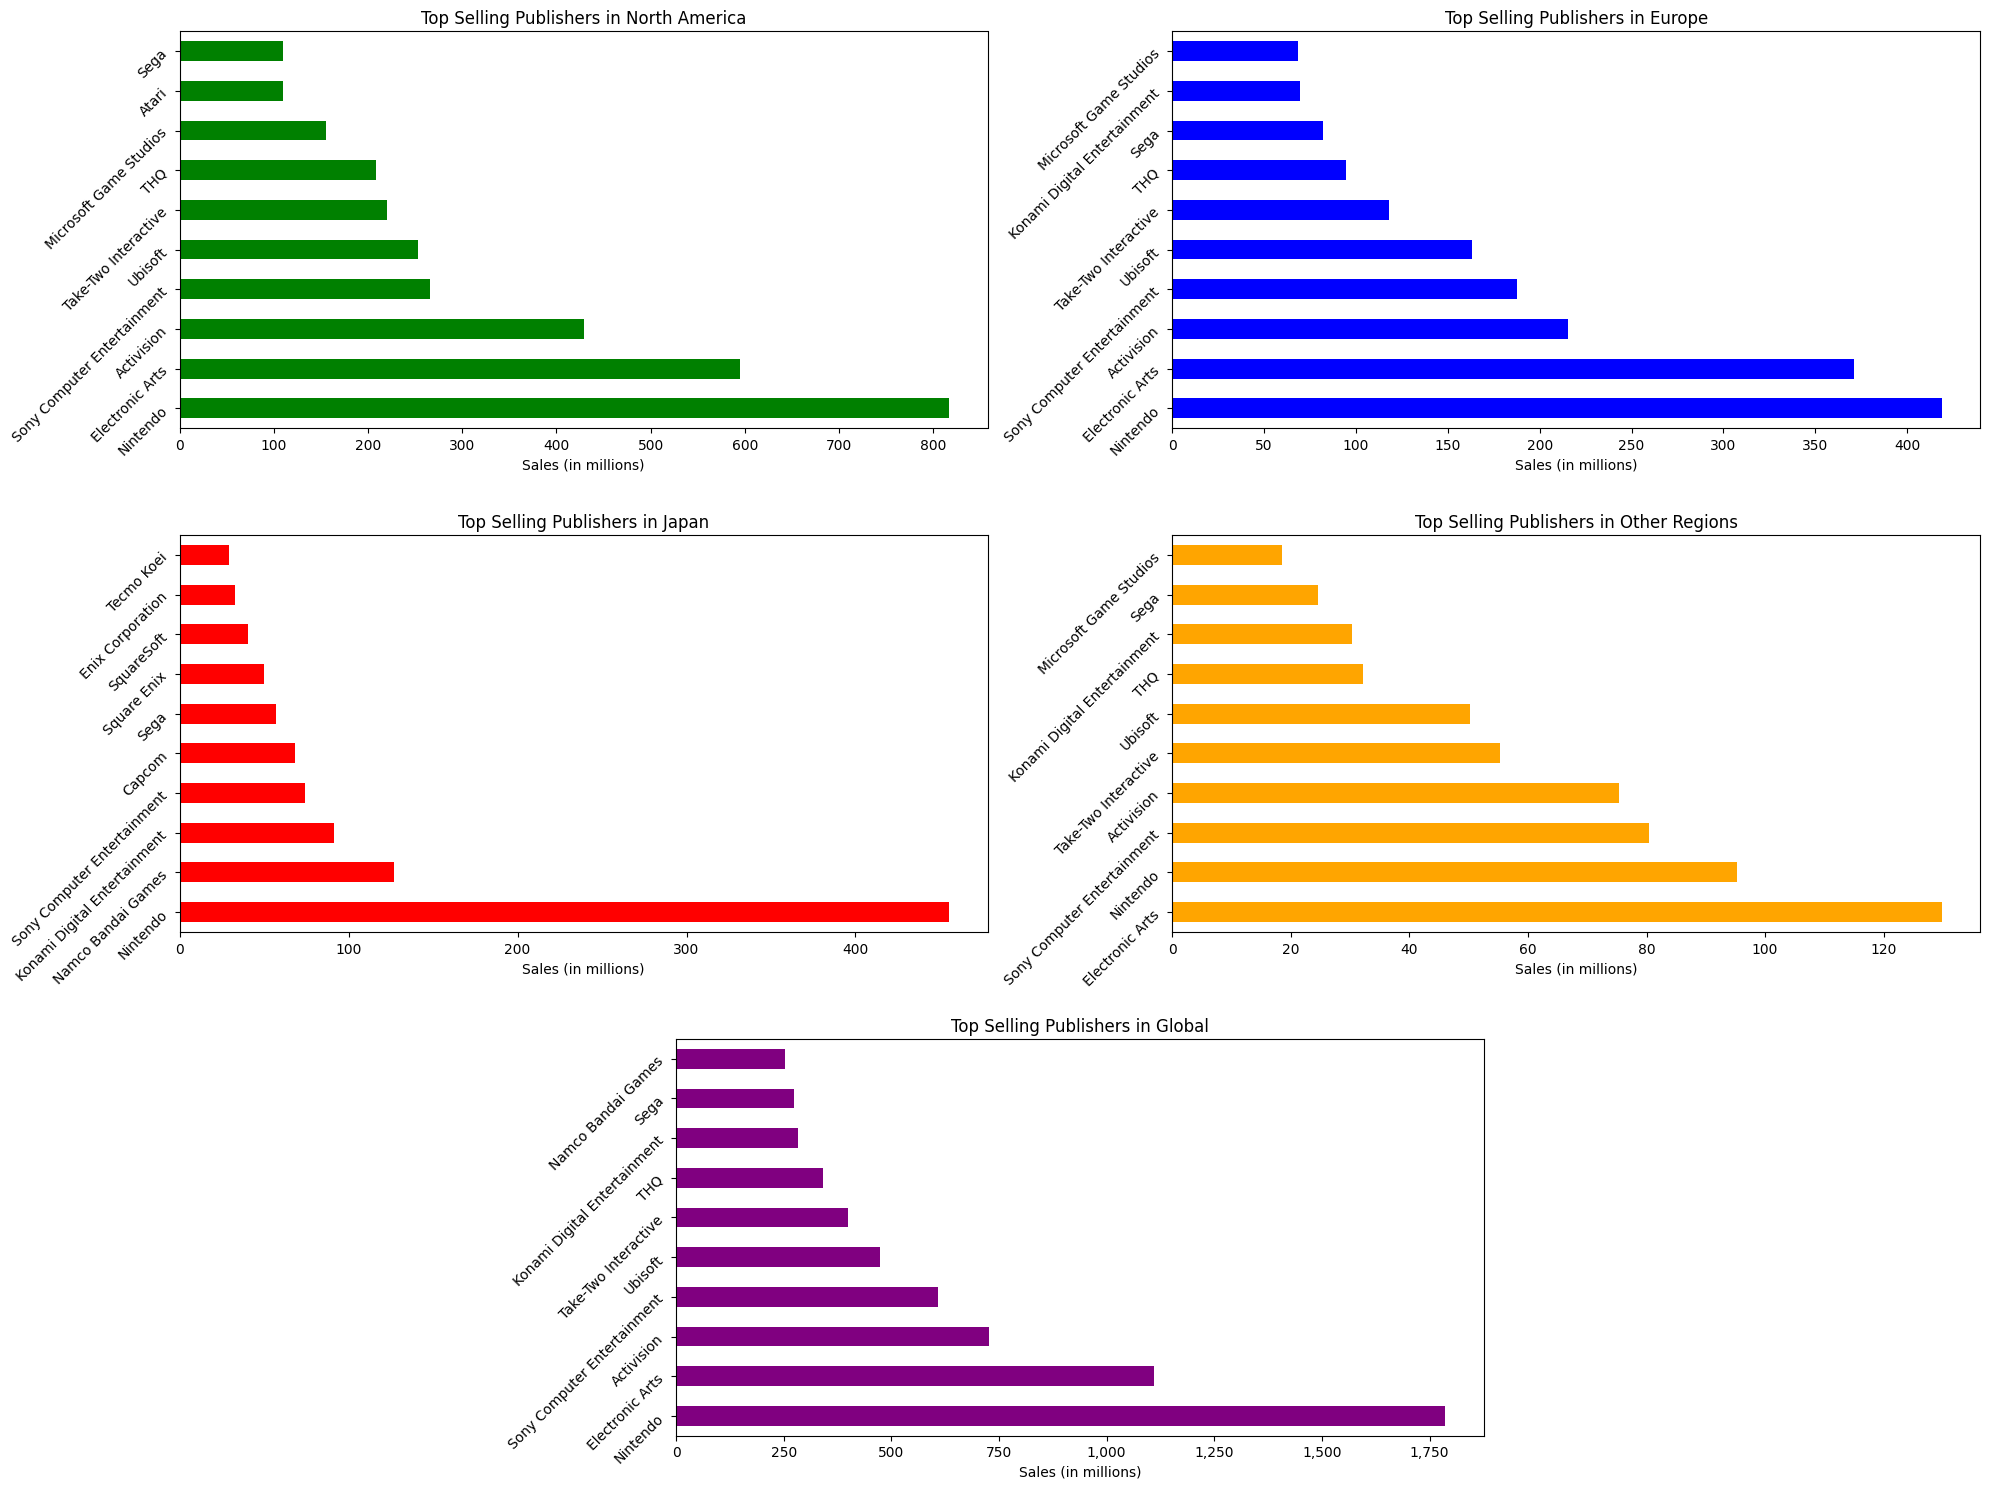

In [16]:
import matplotlib.ticker as mticker
sales_by_publisher_region = df.groupby(['Publisher', 'Platform']).agg({
    'NA_Sales': 'sum',
    'EU_Sales': 'sum',
    'JP_Sales': 'sum',
    'Other_Sales': 'sum',
    'Global_Sales': 'sum'
}).reset_index()

def create_bar_charts(data, region_columns, region_titles, colors, n_top_publishers=10):
    # Adjust the size of the entire figure to give more space for the labels
    plt.figure(figsize=(20, 15))

    # Setup the axes for the grid of bar charts
    ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 4), (0, 2), colspan=2)
    ax3 = plt.subplot2grid((3, 4), (1, 0), colspan=2)
    ax4 = plt.subplot2grid((3, 4), (1, 2), colspan=2)
    ax5 = plt.subplot2grid((3, 4), (2, 1), colspan=2)  # Global sales in the middle
    
    axes = [ax1, ax2, ax3, ax4, ax5]

    # Plot each region's top publishers
    for i, region in enumerate(region_columns):
        ax = axes[i]
        # Only get the top N publishers for each region to reduce clutter
        top_publishers = data.groupby('Publisher')[region].sum().sort_values(ascending=False).head(n_top_publishers)
        top_publishers.plot(kind='barh', color=colors[i], ax=ax)
        
        # Set the title and adjust the x-axis formatter to add commas
        ax.set_title(f'Top Selling Publishers in {region_titles[i]}')
        ax.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
        ax.set_xlabel('Sales (in millions)')
        ax.set_ylabel('')

        # If we want to rotate the y-tick labels (publishers), we can do so here
        for label in ax.get_yticklabels():
            label.set_rotation(45)
            label.set_ha('right')

    plt.tight_layout()  # This will fit subplots within the figure area.
    plt.show()

region_cols = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
region_names = ['North America', 'Europe', 'Japan', 'Other Regions', 'Global']
chart_colors = ['green', 'blue', 'red', 'orange', 'purple']

# Assuming sales_by_publisher_region is already defined as shown in the previous messages
create_bar_charts(sales_by_publisher_region, region_cols, region_names, chart_colors, n_top_publishers=10)

# Global Sales by Platform and Genre
This code snippet creates a heatmap that shows the total global sales of video games by platform and genre. This visualization helps us understand the game genres preference of each platform.

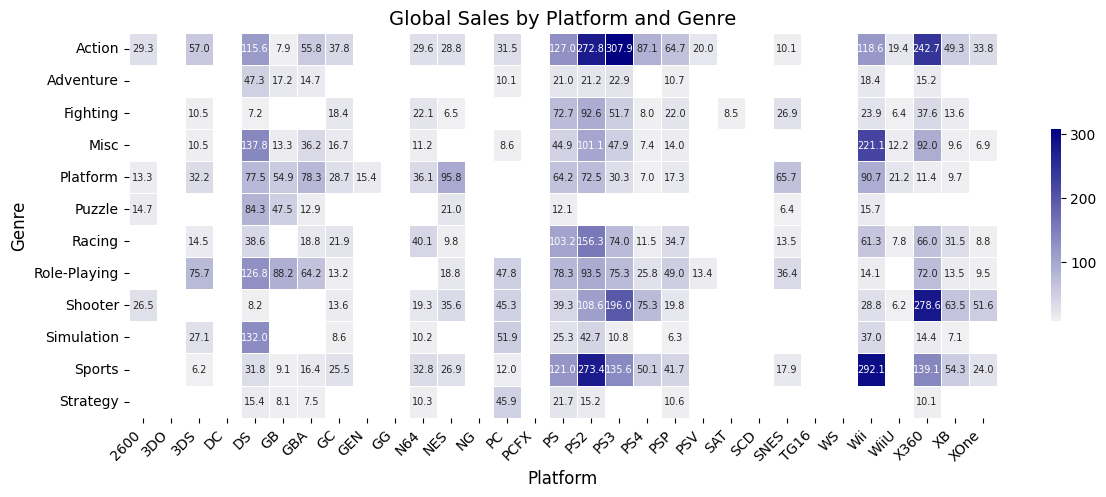

In [6]:
# Create the pivot table
pivot = df.pivot_table(index='Genre', columns='Platform', values='Global_Sales', aggfunc='sum')

# Set threshold for masking
threshold = pivot.max().quantile(0.25)

mask = pivot.apply(lambda x: x < threshold, axis=1)

plt.figure(figsize=(14, 5))
cmap = sns.light_palette("navy", as_cmap=True)
sns.heatmap(pivot, mask=mask, cmap=cmap, linewidths=.5, annot=True, fmt=".1f", cbar_kws={'shrink': .5},
            annot_kws={"size": 7})

plt.xticks(rotation=45, ha='right', size=10)
plt.yticks(size=10)
plt.title('Global Sales by Platform and Genre', size=14)
plt.xlabel('Platform', size=12)
plt.ylabel('Genre', size=12)

plt.show()